# Model Metrics workflow notebook

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/creds/ML4CC_creds.json"

## Step 1: Get config

In [3]:
from src.models.config_setup import get_default_config

model_type = "unet_dropout"
path_to_models = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods_uncertainty_demo/model.pt"
config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_uncertainty.json')
config = get_default_config(config_fp)
config["data_params"]

Loaded Config for experiment:  worldfloods_uncertainty_demo
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                       'window_size': [256, 2

{'loader_type': 'local',
 'num_workers': 8,
 'bucket_id': 'ml4floods',
 'path_to_splits': '/worldfloods/public',
 'train_test_split_file': 'worldfloods/public/train_test_split.json',
 'input_folder': 'S2',
 'target_folder': 'gt',
 'batch_size': 32,
 'window_size': [256, 256],
 'channel_configuration': 'all',
 'train_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True},
 'test_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True}}

In [4]:
config["data_params"]

{'loader_type': 'local',
 'num_workers': 8,
 'bucket_id': 'ml4floods',
 'path_to_splits': '/worldfloods/public',
 'train_test_split_file': 'worldfloods/public/train_test_split.json',
 'input_folder': 'S2',
 'target_folder': 'gt',
 'batch_size': 32,
 'window_size': [256, 256],
 'channel_configuration': 'all',
 'train_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True},
 'test_transformation': {'num_classes': 3,
  'totensor': True,
  'normalize': True}}

## Step 2: Load dataloader

In [5]:
from src.models import dataset_setup

# Configure the dataset to load directly from the Google bucket
config["data_params"]["loader_type"] = "local"
config["data_params"]["bucket_id"] = "ml4floods"
config["data_params"]["path_to_splits"] = "/worldfloods/public/"

# train_transform, test_transform = dataset_setup.get_transformations(config["data_params"])

In [6]:
data_module = dataset_setup.get_dataset(config["data_params"])

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


In [12]:
dl = data_module.test_dataloader()

## Load a pre-trained model

In [24]:
config.model_params.hyperparameters.model_type = "unet_dropout"
model_type = config.model_params.hyperparameters.model_type
print('Model type: ', model_type)
# path_to_models = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods_uncertainty_demo/model.pt"
path_to_models = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/worldfloods_uncertainty_demo/checkpoint/epoch=7-step=49167.ckpt"

Model type:  unet_dropout


In [32]:
from pytorch_lightning.utilities.cloud_io import load
from src.models.model_setup import get_model
import torch

model = get_model(config.model_params)
# model.load_state_dict(load(path_to_models))
checkpoint_sd = load(path_to_models)
print(checkpoint_sd.keys())
model.load_state_dict(checkpoint_sd['state_dict'])
# model.load_from_checkpoint(path_to_models)
model.to(torch.device("cuda:0"))

13 3
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])


WorldFloodsModel(
  (network): UNet_dropout(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=

In [15]:
# from src.models import model_setup
# from imp import reload
# reload(model_setup)

In [16]:
cosa = next(iter(dl))
cosa["image"].shape
rgb_2_show = model.batch_to_unnorm_rgb(cosa["image"])
rgb_2_show.shape

(1, 2643, 2170, 3)

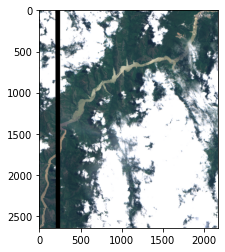

In [17]:
import matplotlib.pyplot as plt

plt.imshow(rgb_2_show[0])

In [35]:
from src.models.model_setup import get_model_inference_function

# print(model.network.upsample)
print('max_tile', config.model_params.hyperparameters.max_tile_size)
config.model_params.hyperparameters.max_tile_size = 256
print('max_tile', config.model_params.hyperparameters.max_tile_size)
inference_function = get_model_inference_function(model, config,apply_normalization=False, eval_mode=False)

max_tile 256
max_tile 256
GEtting model inference function
Max tile size: 256


100%|██████████| 11/11 [02:26<00:00, 13.31s/it]


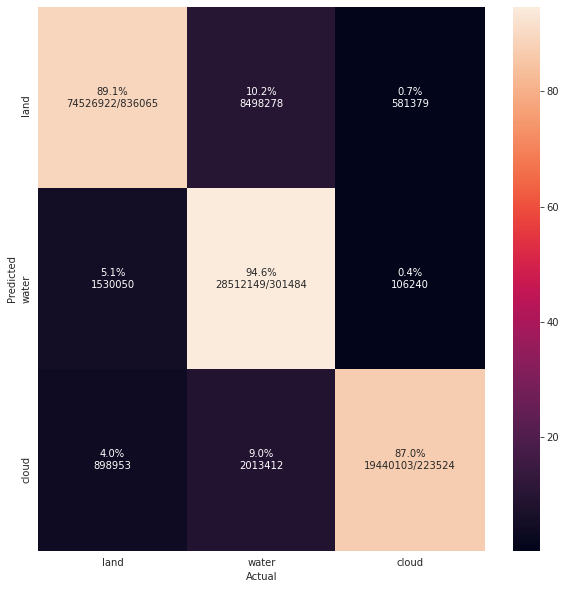

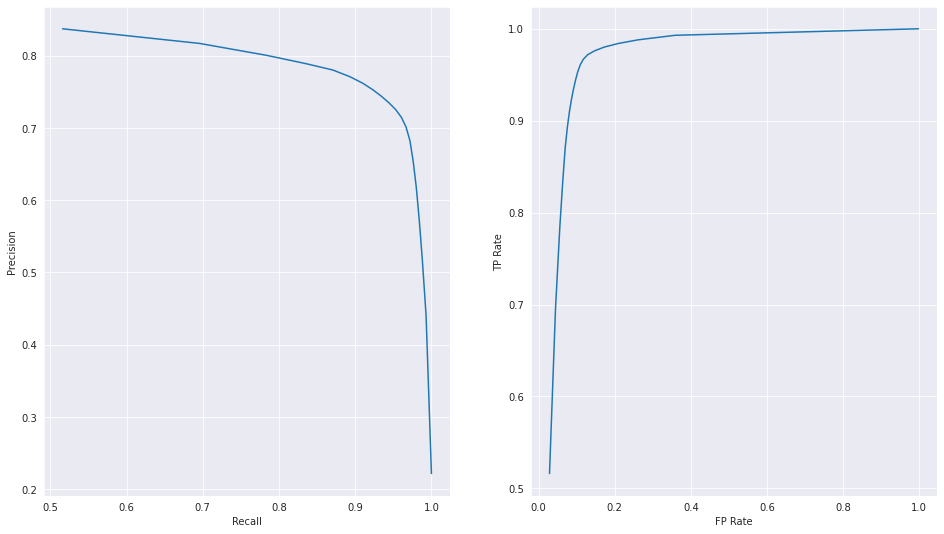

Per Class IOU {
    "cloud": 0.8437512844461047,
    "land": 0.8662337171148561,
    "water": 0.7012311495617733
}


In [36]:
import torch
import numpy as np
import pandas as pd
from src.models.utils import metrics

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    config.model_params.hyperparameters.num_classes, 
    label_names=config.model_params.hyperparameters.label_names, 
    thresholds_water=np.arange(0, 1, .05), 
    plot=False)
metrics.plot_metrics(mets, config.model_params.hyperparameters.label_names)

In [16]:
# mets = metrics.compute_metrics(dl, inference_func2, opt2.num_class, label_names, thresholds_water=np.arange(0, 1, .05), plot=True)
# metrics.plot_metrics(mets, label_names)